### Logistic Regression models

**Objective**: This notebook aims to analyse customer reviews using Logistic Regression models to predict certain outcomes based on the text data. The goal is to understand the sentiment or other characteristics of the reviews that could be beneficial for business insights.

**Methodology**: We have employed Logistic Regression with L1 regularisation to optimise the model's performance, which helps in feature selection by penalising less important features. The data is vectorised using 1 and 2-grams to capture the context within the text effectively. 

**Data**: The analysis uses a dataset of customer reviews that has been preprocessed and vectorized. The dataset was split into training and testing sets, with downsampling applied to address class imbalance, ensuring that our model is robust and less biased. I run the optimisation on each dataset and compare the results.

**Key Findings**: The top three words associated with positive reviews are "love", "great" and "perfect". The top three words associated with negative reviews are "return", "broke" and "waste". This is consistant between both models. The model on unbalanced data scored an accuracy of $0.72$, and the model on balanced data achieved an accuracy of $0.79$. More analysis takes place in the notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV


from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.pipeline import Pipeline, FeatureUnion


from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, RocCurveDisplay, auc

from source import downsample_binary, my_tokenizer
import joblib

In [2]:
tfidf = TfidfVectorizer(min_df=10,tokenizer = my_tokenizer, max_features=500)
tfidf_2grams = TfidfVectorizer(min_df=10,tokenizer = my_tokenizer, max_features=100, ngram_range=(2,2))
# feature union to combine 1-gram and 2-gram features
combined_features = FeatureUnion([
    ('1gram', tfidf),
    ('2gram', tfidf_2grams)
])

Begin by reading in the data, then I will optimise for best C value using $L1$ Regression. Before doing this, I will split the data into test and train, and make a copy of the train set before downsampling the majority class. I will train two logistic regressions on each dataset and compare the results. I am using the vectorisation with 1 and 2-grams

In [3]:
df = pd.read_pickle("../data/reviews_vector_FINAL.pkl")


In [4]:
# Splitting the main data
X=df.drop("binary",axis=1)
y=df["binary"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [5]:
test_later = X_test

In [6]:
#downsampling X_train
balanced_set = downsample_binary(y_train, X_train)

In [7]:
X_train_unvec = X_train["reviewText"]
X_train = X_train[X_train.columns[4:]]
X_test_unvec = X_test["reviewText"]
X_test = X_test[X_test.columns[4:]]


In [8]:
# balanced class training sets
X_train_bal = balanced_set[balanced_set.columns[5:]]
y_train_bal = balanced_set["binary"]

X_train_bal_unvec = balanced_set["reviewText"]



In [9]:
X_train_bal_unvec.shape, y_train_bal.shape


((271596,), (271596,))

In [10]:
X_train.duplicated().sum()

62367

In [11]:
y_train.value_counts(normalize=True)

binary
1    0.761183
0    0.238817
Name: proportion, dtype: float64

In [12]:
# checking that the downsample worked
y_train.value_counts(), y_train_bal.value_counts()

(binary
 1    432829
 0    135798
 Name: count, dtype: int64,
 binary
 0    135798
 1    135798
 Name: count, dtype: int64)

### Optimizing a Logistic Regression on the original unbalanced data


In [13]:
# instansiate the pipeline
estimators = [('model', LogisticRegression(C=1,penalty='l1', solver='liblinear',random_state=42))]
pipe = Pipeline(estimators)


In [25]:
# run a grid search for the model on unbalanced data
params = {
    'model__penalty':['l1'],
    'model__solver':['liblinear'],
    'model__C': [0.1,1,10,15],
    'model__random_state':[42]    
}

grid_search = GridSearchCV(pipe, param_grid=params, verbose=3, n_jobs=2)

In [26]:
# fit the grid search
fittedgrid = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END model__C=0.1, model__penalty=l1, model__random_state=42, model__solver=liblinear, normalise=StandardScaler();, score=0.857 total time= 2.5min
[CV 2/5] END model__C=0.1, model__penalty=l1, model__random_state=42, model__solver=liblinear, normalise=StandardScaler();, score=0.858 total time= 2.6min
[CV 3/5] END model__C=0.1, model__penalty=l1, model__random_state=42, model__solver=liblinear, normalise=StandardScaler();, score=0.856 total time= 2.2min
[CV 4/5] END model__C=0.1, model__penalty=l1, model__random_state=42, model__solver=liblinear, normalise=StandardScaler();, score=0.857 total time= 2.3min
[CV 5/5] END model__C=0.1, model__penalty=l1, model__random_state=42, model__solver=liblinear, normalise=StandardScaler();, score=0.857 total time= 2.5min
[CV 1/5] END model__C=1, model__penalty=l1, model__random_state=42, model__solver=liblinear, normalise=StandardScaler();, score=0.857 total time= 2.4min
[CV 3/5] END

In [ ]:
fittedgrid.best_estimator_

In [14]:

estimators = [('vectorize', combined_features), 
              ('model', LogisticRegression(C=10,penalty='l1', solver='liblinear',random_state=42))]
pipe_final = Pipeline(estimators, verbose=True)
pipe_final.fit(X_train_unvec, y_train)

/Users/edo/anaconda3/envs/es_capstone/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[Pipeline] ......... (step 1 of 2) Processing vectorize, total= 4.0min
[Pipeline] ............. (step 2 of 2) Processing model, total=   1.9s


Pipeline(steps=[('vectorize',
                 FeatureUnion(transformer_list=[('1gram',
                                                 TfidfVectorizer(max_features=500,
                                                                 min_df=10,
                                                                 tokenizer=<function my_tokenizer at 0x28d2ef5e0>)),
                                                ('2gram',
                                                 TfidfVectorizer(max_features=100,
                                                                 min_df=10,
                                                                 ngram_range=(2,
                                                                              2),
                                                                 tokenizer=<function my_tokenizer at 0x28d2ef5e0>))])),
                ('model',
                 LogisticRegression(C=10, penalty='l1', random_state=42,
                                    solver='liblinear'))],
         verbose=True)

In [150]:
len(pipe_final[0].get_feature_names_out())

600

### Optimizing a Logistic Regression on the balanced data


In [14]:
# instansiate the balanced pipeline
estimators_bal = [
              ('model', LogisticRegression(C=1,penalty='l1', solver='liblinear',random_state=42))]
pipe_bal = Pipeline(estimators_bal)

In [15]:
# run a grid search for the model on balanced data
params_bal = {
    'model__C': [0.1,1,10],
    'model__random_state':[42]
    
}

grid_search_bal = GridSearchCV(pipe_bal, param_grid=params_bal, verbose=3, n_jobs=2)

In [ ]:
fittedgrid_bal = grid_search_bal.fit(X_train, y_train)

In [ ]:
fittedgrid_bal.best_estimator_

In [15]:
estimators_bal = [('vectorize', combined_features), 
              ('model', LogisticRegression(C=10,penalty='l1', solver='liblinear',random_state=42))]
pipe_final_bal  = Pipeline(estimators_bal, verbose=True)
pipe_final_bal.fit(X_train_bal_unvec, y_train_bal)

/Users/edo/anaconda3/envs/es_capstone/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[Pipeline] ......... (step 1 of 2) Processing vectorize, total= 1.9min
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.9s


Pipeline(steps=[('vectorize',
                 FeatureUnion(transformer_list=[('1gram',
                                                 TfidfVectorizer(max_features=500,
                                                                 min_df=10,
                                                                 tokenizer=<function my_tokenizer at 0x28d2ef5e0>)),
                                                ('2gram',
                                                 TfidfVectorizer(max_features=100,
                                                                 min_df=10,
                                                                 ngram_range=(2,
                                                                              2),
                                                                 tokenizer=<function my_tokenizer at 0x28d2ef5e0>))])),
                ('model',
                 LogisticRegression(C=10, penalty='l1', random_state=42,
                                    solver='liblinear'))],
         verbose=True)

## Analysis

We now have ```pipe_final``` on the unbalanced data and ```pipe_final_bal``` on the balanced data. We can now compare the two.

In [16]:
log_clas = pipe_final[-1]
log_clas_bal = pipe_final_bal[-1]

In [17]:
# predictions for unbalanced
y_pred_train = pipe_final.predict(X_train_unvec)
y_pred_test = pipe_final.predict(X_test_unvec)

In [18]:
# predictions for balanced
y_pred_train_bal = pipe_final_bal.predict(X_train_bal_unvec)
y_pred_test_bal = pipe_final_bal.predict(X_test_unvec)


In [19]:
# for ROC later
y_proba_test = pipe_final.predict_proba(X_test_unvec)
y_proba_test_bal = pipe_final_bal.predict_proba(X_test_unvec)

In [20]:
accuracy_score(y_train, y_pred_train),accuracy_score(y_test, y_pred_test)

(0.7348244103779806, 0.7341882566458212)

In [21]:
accuracy_score(y_train_bal, y_pred_train_bal),accuracy_score(y_test, y_pred_test_bal)

(0.8237013799908688, 0.8170895559135323)

## Plotting highest coefficients for positive and negative sentiment

In [22]:
log_clas.coef_.shape

(1, 600)

In [23]:
X_train.columns

Index(['1gram__10', '1gram__100', '1gram__6s', '1gram__abl', '1gram__absolut',
       '1gram__access', '1gram__actual', '1gram__ad', '1gram__adapt',
       '1gram__add',
       ...
       '2gram__well made', '2gram__work fine', '2gram__work good',
       '2gram__work great', '2gram__work like', '2gram__work perfectli',
       '2gram__work well', '2gram__would buy', '2gram__would definit',
       '2gram__would recommend'],
      dtype='object', length=600)

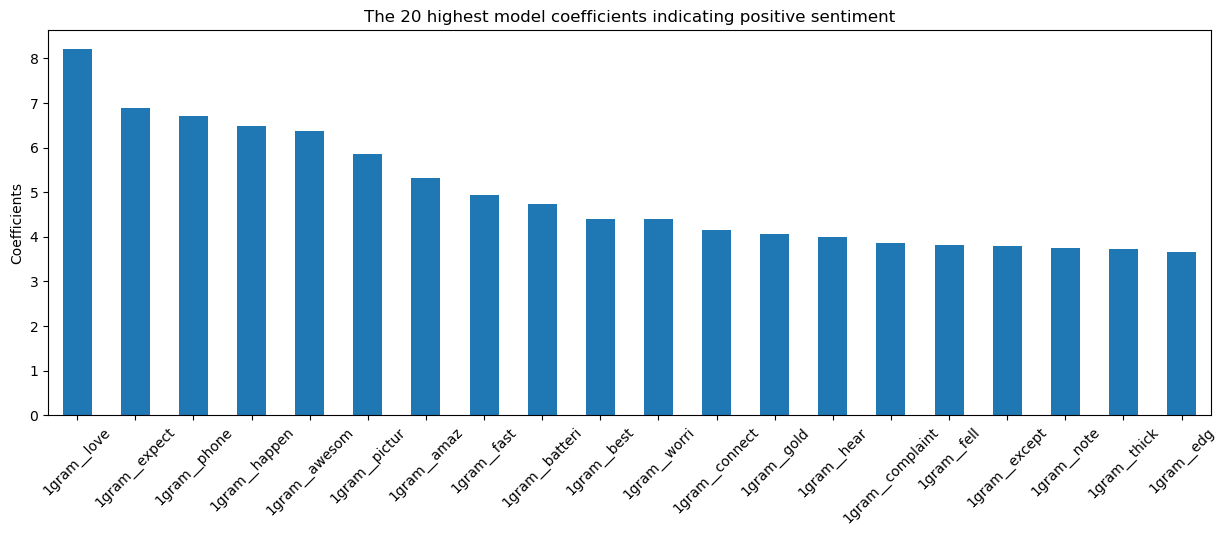

In [24]:
word_counts = pd.DataFrame(
    {"coefficients": log_clas.coef_[0]},
    index=pipe_final[0].get_feature_names_out()
).sort_values("coefficients", ascending=False)
word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)

plt.title("The 20 highest model coefficients indicating positive sentiment")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

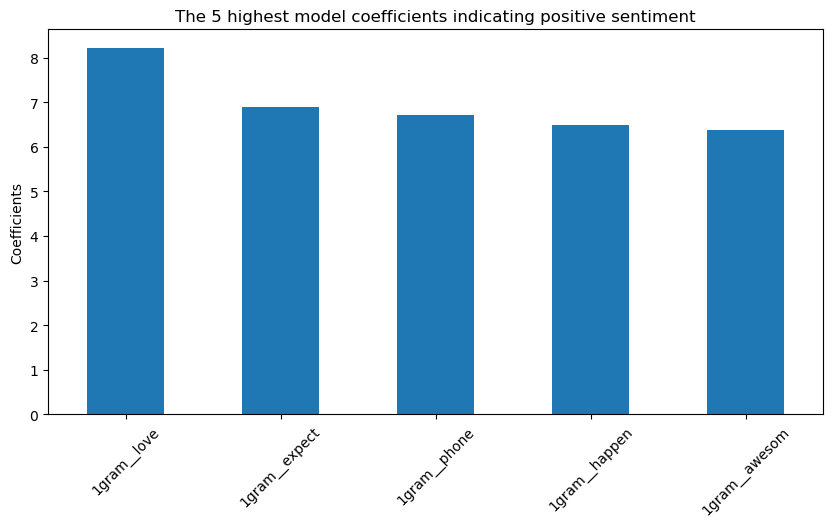

In [25]:
word_counts.head(5).plot(kind="bar", figsize=(10, 5), legend=False)

plt.title("The 5 highest model coefficients indicating positive sentiment")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

We can see that the model identifies these words as the top words sigifying positive signal. This is reasonable as these words are positive

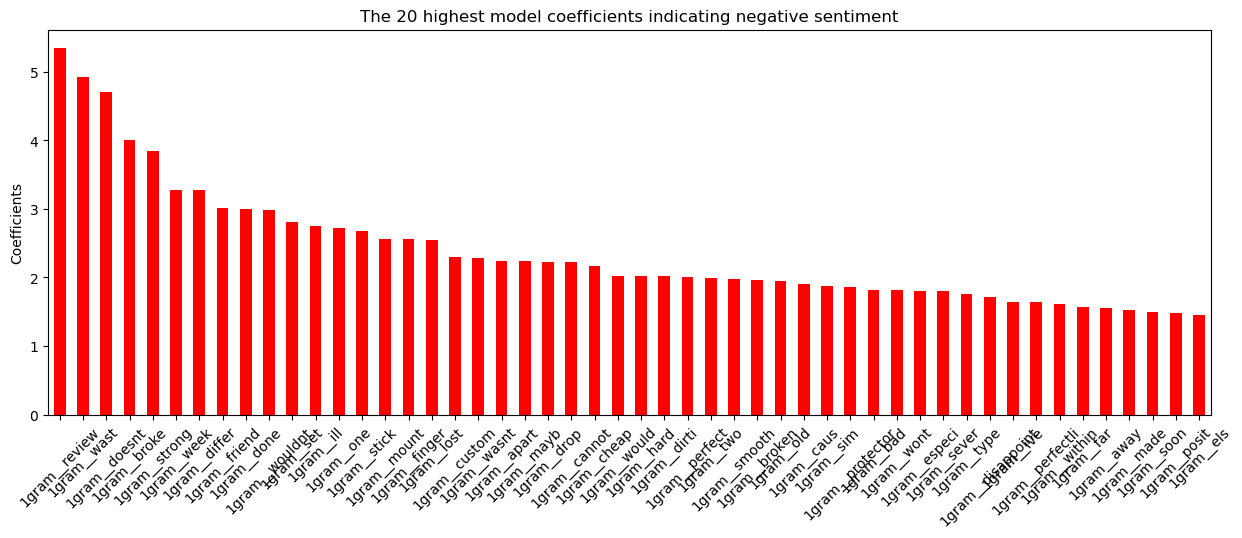

In [26]:
word_counts2 = pd.DataFrame(
    {"coefficients": log_clas.coef_[0]},
    index=pipe_final[0].get_feature_names_out()
).sort_values("coefficients", ascending=True)

word_counts2.head(50).abs().plot(kind="bar", figsize=(15, 5), legend=False, color='red')

plt.title("The 20 highest model coefficients indicating negative sentiment")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

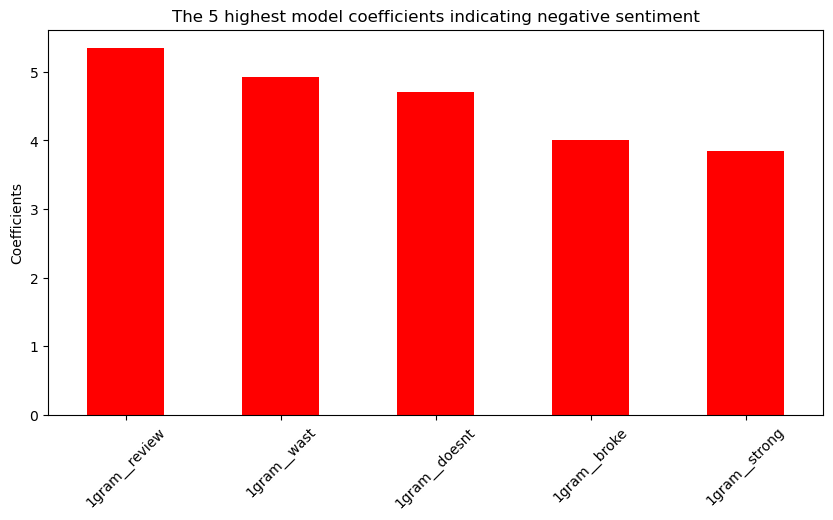

In [27]:
word_counts2.head(5).abs().plot(kind="bar", figsize=(10, 5), legend=False, color='red')

plt.title("The 5 highest model coefficients indicating negative sentiment")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

Here are the top 5 words signifiying negative reviews. 

In [28]:
p = word_counts.head(5)
n = word_counts2.head(5)
p.columns = ['pos']
n.columns = ['neg']
p_and_n = pd.concat([p,n])
p_and_n

,pos,neg
1gram__love,8.217851,NaN
1gram__expect,6.894379,NaN
1gram__phone,6.706986,NaN
1gram__happen,6.483171,NaN
1gram__awesom,6.378915,NaN
1gram__review,NaN,-5.346347
1gram__wast,NaN,-4.929243
1gram__doesnt,NaN,-4.707119
1gram__broke,NaN,-3.999686
1gram__strong,NaN,-3.840492


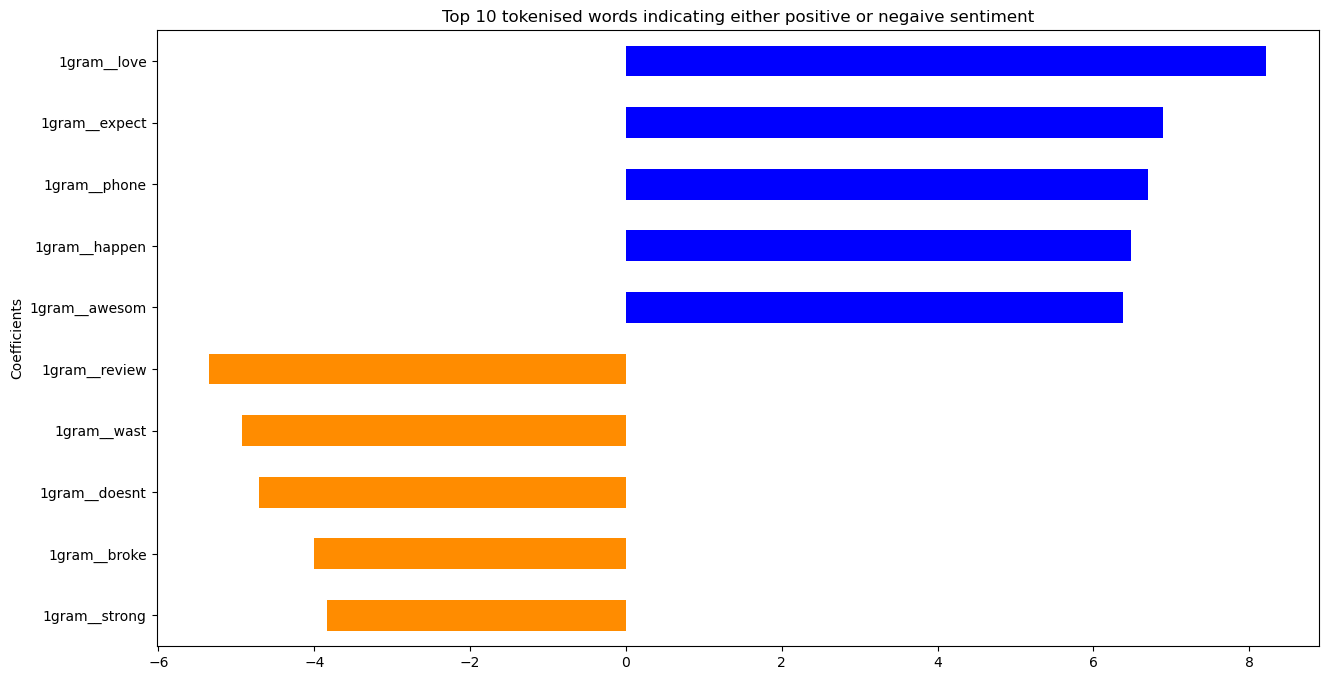

In [29]:
# coloring from https://stackoverflow.com/questions/3832809/how-to-change-the-color-of-a-single-bar-if-condition-is-true
stacked_data = p_and_n.stack().reset_index()
stacked_data.columns = ['feature', 'type', 'coefficient']
stacked_data
sorted_data = stacked_data.sort_values(by='coefficient', key=abs, ascending=True)

colors = ['blue' if tp=="pos"  else 'darkorange' for tp in sorted_data['type']]

# plot
plt.figure(figsize=(15,8))
sorted_data.set_index('feature')['coefficient'].plot(kind="barh", color=colors, legend=False)
plt.title("Top 10 tokenised words indicating either positive or negaive sentiment")
plt.ylabel("Coefficients")
plt.xticks(rotation=0)
plt.show()

The same results for the balanced data, but in a slightly different order. It is interesting that no 2-grams were chosen as very important. maybe this was an unececary step and we can test this in future.

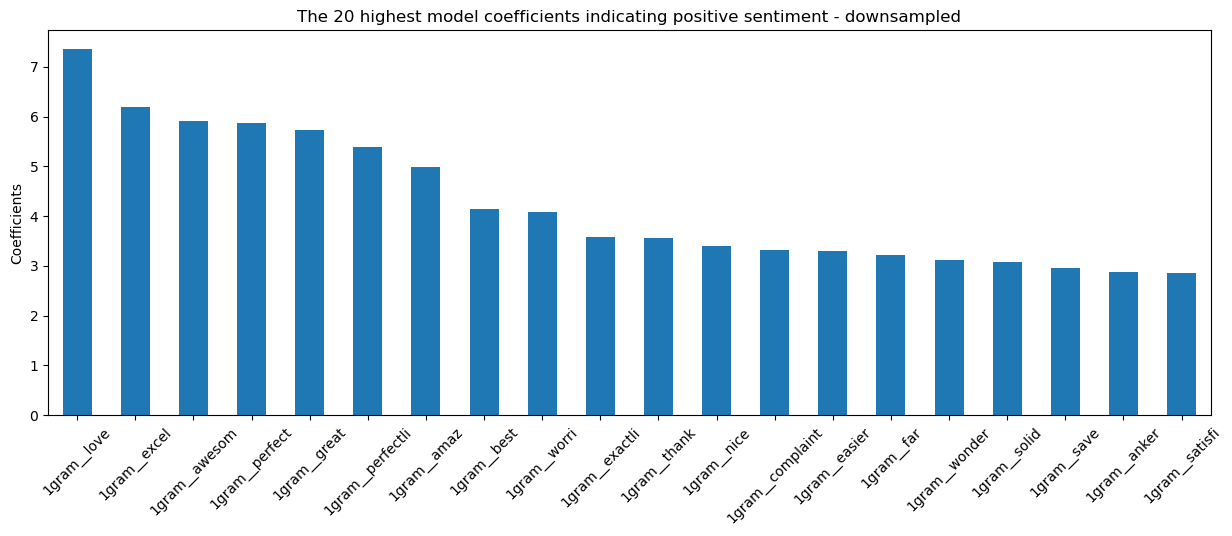

In [30]:
word_counts = pd.DataFrame(
    {"coefficients": log_clas_bal.coef_[0]},
    index=pipe_final_bal[0].get_feature_names_out()
).sort_values("coefficients", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)

plt.title("The 20 highest model coefficients indicating positive sentiment - downsampled")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

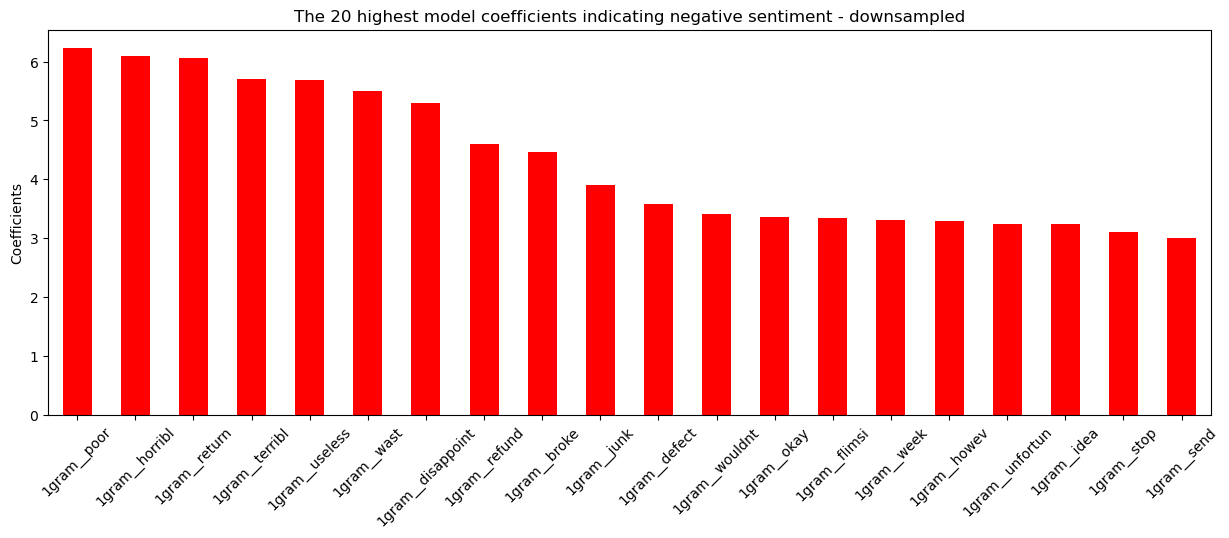

In [31]:
word_counts = pd.DataFrame(
    {"coefficients": log_clas_bal.coef_[0]},
    index=pipe_final_bal[0].get_feature_names_out()
).sort_values("coefficients", ascending=True)

word_counts.head(20).abs().plot(kind="bar", figsize=(15, 5), legend=False, color='red')

plt.title("The 20 highest model coefficients indicating negative sentiment - downsampled")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

We see that both in the positive and negative reviews the same words appear, although in slightly different orders. Many words we expect such as love, great, perfect indicate positive reviews, whilst words such as return waste dissapoint indicate a negative review. Lets look further into the predictions

In [32]:
joblib.dump(pipe_final, "../model/logistic-unbal-model.pkl")
joblib.dump(pipe_final_bal, "../model/logistic-bal-model.pkl")



['../model/logistic-bal-model.pkl']

Confusion matrix

In [186]:
# unbalanced
cm = confusion_matrix(y_test, y_pred_test)
cm_norm = confusion_matrix(y_test, y_pred_test , normalize="true")

In [187]:
# balanced
cm_bal = confusion_matrix(y_test, y_pred_test_bal)
cm_bal_norm = confusion_matrix(y_test, y_pred_test_bal, normalize="true")

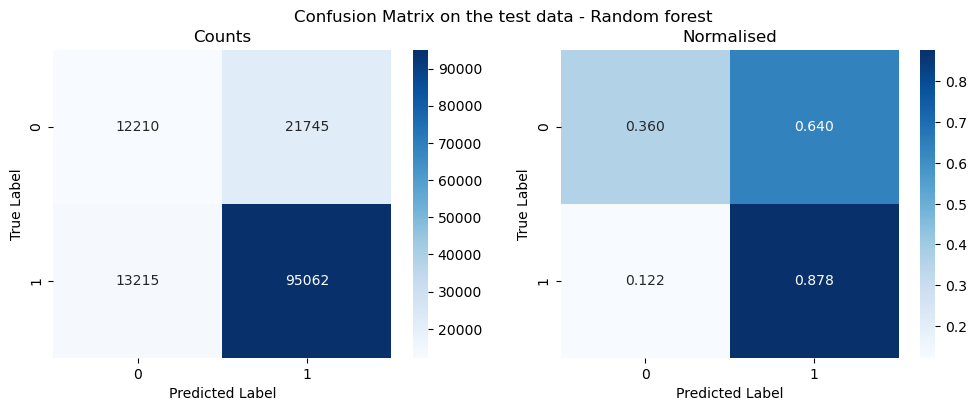

In [198]:
plt.subplots(1,2, figsize=(12, 4))
plt.subplot(1,2,1)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Counts")
plt.subplot(1,2,2)
sns.heatmap(cm_norm, annot=True, fmt=".3f", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalised")
plt.suptitle("Confusion Matrix on the test data - Random forest")
plt.show()


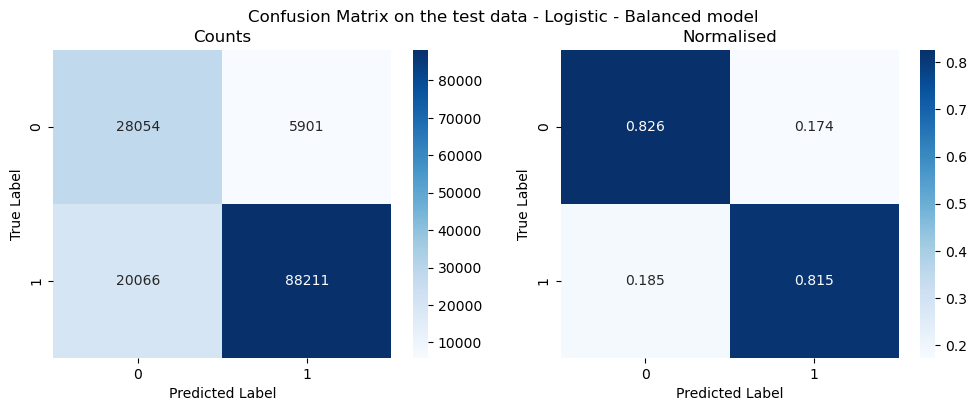

In [199]:
plt.subplots(1,2, figsize=(12, 4))
plt.subplot(1,2,1)
sns.heatmap(cm_bal, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Counts")
plt.subplot(1,2,2)
sns.heatmap(cm_bal_norm, annot=True, fmt=".3f", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalised")
plt.suptitle("Confusion Matrix on the test data - Logistic - Balanced model")
plt.show()


we see that the first logistic regression is very good at predicting negative reviews, which is interesting as there are very few of them in comparison. however, it has overfitted, and predicts many positive reviews as negative.

The regression on the balanced data does better on positive reviews and slightly worse on negative, hwoever, it gets less wrong overall

In [200]:
fpr_unbal, tpr_unbal, thresholds_unbal = roc_curve(y_test.values,y_proba_test[:,1])
roc_auc1 = auc(fpr_unbal, tpr_unbal)


In [201]:
fpr_bal, tpr_bal, thresholds_bal = roc_curve(y_test.values,y_proba_test_bal[:,1])
roc_auc2 = auc(fpr_bal, tpr_bal)


We can see how the ROC changes as we change the confidence thresehold. It shows we could try vary it and compare.

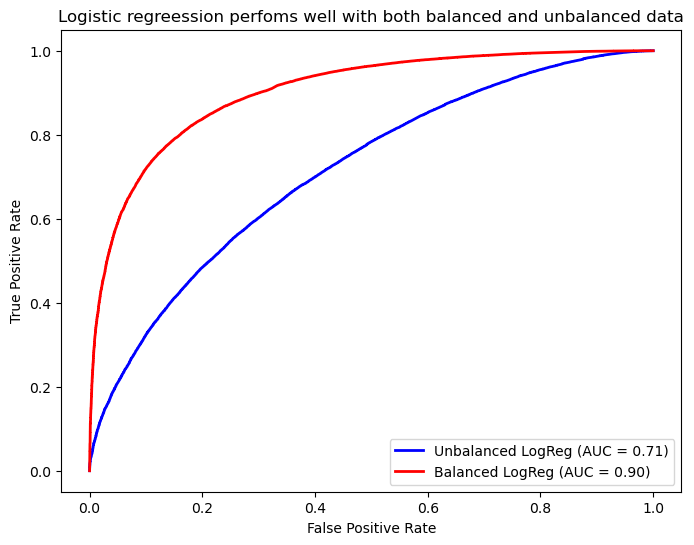

In [359]:
plt.figure(figsize=(8, 6))

# ROC curve for unbalanced model
plt.plot(fpr_unbal, tpr_unbal, color='blue', lw=2, label='Unbalanced LogReg (AUC = %0.2f)' % roc_auc1)

# ROC curve for balanced model
plt.plot(fpr_bal, tpr_bal, color='red', lw=2, label='Balanced LogReg (AUC = %0.2f)' % roc_auc2)

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic regreession perfoms well with both balanced and unbalanced data')
plt.legend()


plt.show()

Really poor precision of the 0 class, and bad recall on the 1 class. It "performs well" by guessing 0 a lot. Then when its very confident it guesses 1 and gets it right, but misclassifies many positive reviews as negative.

In [273]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.48      0.36      0.41     33955
           1       0.81      0.88      0.84    108277

    accuracy                           0.75    142232
   macro avg       0.65      0.62      0.63    142232
weighted avg       0.73      0.75      0.74    142232



In [260]:
print(classification_report(y_test, y_pred_test_bal))

              precision    recall  f1-score   support

           0       0.58      0.83      0.68     33955
           1       0.94      0.81      0.87    108277

    accuracy                           0.82    142232
   macro avg       0.76      0.82      0.78    142232
weighted avg       0.85      0.82      0.83    142232



Similar results, but better overall at guessing each class.

In [279]:
y_pred_test = pd.Series(y_pred_test, index=y_test.index)
y_pred_test

54698     1
393008    1
669376    1
395127    1
525069    1
         ..
617942    1
514183    1
244054    1
337620    1
449312    1
Length: 142232, dtype: int64

In [292]:

incorrect_guesses = y_test != y_pred_test

incorrect_v = pd.Series(y_test)[incorrect_guesses]
ig = pd.concat([y_pred_test[incorrect_guesses],pd.Series(incorrect_v), test_later[incorrect_guesses]], axis=1)
ig.rename(columns={0:"guess"}, inplace=True)

In [293]:
ig.head()

,guess,binary,overall,reviewText,asin,length,10,100,6s,abl,...,well made,work fine,work good,work great,work like,work perfectli,work well,would buy,would definit,would recommend
395127,1,0,1.0,"Don't buy off Amazon, they have for the same p...",B00PA7A3LY,153,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
642051,0,1,4.0,I'm updating my review. Previously I had gotte...,B01G3TN1KC,420,0.0,0.0,0.0,0.198531,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
682538,0,1,5.0,The Ringke slim case is my favorite!,B00KIUG27M,36,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
313764,1,0,2.0,Great case and has very nice look an feel. But...,B00LPJY1ZK,173,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41992,1,0,2.0,"Ehh, they are ok. They might be Genuine, but t...",B005FUNYV2,329,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [294]:
rev = ig.loc[642051]
text = rev["reviewText"]
print(f"Actual: {rev['binary']}, Guess: {rev[0]}, Overall: {int(rev['overall'])}")
print(f"Review: {text[:45]} \n{text[45: 100]} \n{text[101:152]} \n{text[153:]}")

Actual: 1, Guess: 0, Overall: 4
Review: I'm updating my review. Previously I had gott 
en bubbles. They sent a replacement. I was able to inst 
ll this one. It works very well. The guide stickers 
they include are pretty useless. They just aren't sticky enough. And getting perfect alignment is pretty difficult. And if you have pets you're going to have an awful time getting it on with no issues. But assuming you can get it right it's really clear like perfect.


10                      0.0
100                     0.0
6s                      0.0
abl                0.198531
absolut                 0.0
                     ...   
work perfectli          0.0
work well               1.0
would buy               0.0
would definit           0.0
would recommend         0.0
Name: 642051, Length: 600, dtype: object

In [339]:
feature_values = ig.loc[642051,"10":]


In [304]:
log_clas.coef_.shape

(1, 600)

In [350]:
coefficients = log_clas.coef_[0]
contributions = feature_values * coefficients
contributions.sort_values()


replac      -0.941727
difficult   -0.360351
clear       -0.144237
includ      -0.133961
bubbl        -0.11242
               ...   
right          0.2417
well         0.324042
work well    0.405135
pretti       0.520459
perfect      1.692772
Name: 642051, Length: 600, dtype: object

In [356]:
pd.DataFrame(contributions.sort_values()).head(10)

,642051
replac,-0.941727
difficult,-0.360351
clear,-0.144237
includ,-0.133961
bubbl,-0.11242
one,-0.106514
instal,-0.105996
time,-0.094105
like,-0.077266
issu,-0.06713


We see that the positive words swayed the confidence of the model and it misclassified it. Words like love.

In [357]:
intercept = log_clas.intercept_

total_log_odds = contributions.sum() + intercept

probability = 1 / (1 + np.exp(-total_log_odds))

In [358]:
probability

array([0.88977444])